In [1]:
from src import CVE_Functions
from src import LangevinFunctions
from src import StatsFunctions
from src import MSDFunctions
SF_F = StatsFunctions.Statistics_Functions()
CVE_F = CVE_Functions.CVE()
LF_F = LangevinFunctions.LF()
MSD_F = MSDFunctions.MSD()
import numpy as np
import matplotlib.pyplot as plt

In [195]:
delta = np.matrix(np.linspace(-10, 10, 99));
N = 1000;
DT = 10
dT = 0.1
deltaT = dT
sigma0 = 0.01 # 10 nm localisation precision
s0 = 0.25
tE = dT
R = 1./6

In [196]:
n_d = 3
coordinates = LF_F.BrownianTrans_Realistic(DT, N=NSteps, deltaT=dT, n_d=n_d, tE=dT, sigma0=sigma0, s0=s0, R=1./6)
coords = LF_F.BrownianTrans_Ideal(DT, n_d, dT, NSteps)

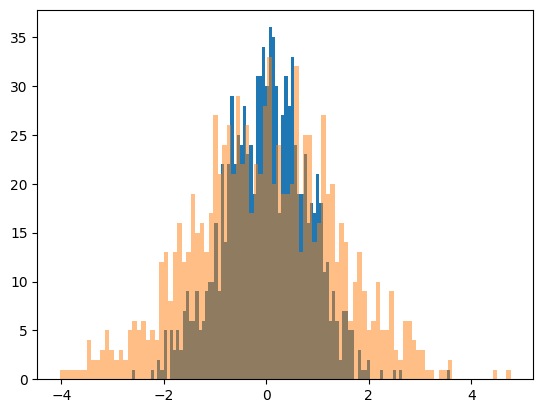

In [197]:
plt.hist(np.diff(coordinates[:, 0]), 100);
plt.hist(np.diff(coords[:, 0]), 100, alpha=0.5);
plt.show()

In [198]:
import scipy.optimize
from scipy.fft import dst


In [199]:
    def likelihood_subfunction(d_xx, D, sig2, dT, R, n_d=1):
        """
        Compute log-likelihood for trajectories of particle tracking.
    
        Args:
            d_xx (numpy.ndarray): Square distance of the difference of 
                                trajectory. Second axis should be n_d
            D (float): Diffusion coefficient.
            sig2 (float): Variance.
            dT (float): Time step.
            R (float): Motion blur coefficient.
            n_d (int): number of dimensions. If above 1, d_xx second
                        dimension should be same shape as this number
    
        Returns:
            L (float): Likelihood value.
        """
        if D < 0 or sig2 < 0:
            # Return negative infinity if D or sig2 is negative
            return -np.inf
    
        if n_d > 1:
            try:
                if d_xx.shape[1] != n_d:
                    raise Exception('Dimension of d_xx and n_d are inconsistent.')
            except Exception as error:
                print('Caught this error: ' + repr(error))
                return
            
        L = 0. # initialise L
        N = d_xx.shape[0]
        # Calculate parameters for the likelihood computation
        alpha = 2 * D * dT * (1 - 2 * R) + 2 * sig2
        beta = 2 * R * D * dT - sig2
        # Compute the eigenvalues vector
        eigvec = alpha + 2 * beta * np.cos(np.pi * np.arange(1, N + 1) / (N + 1))
        eigvec = eigvec.reshape(d_xx.shape[0])
        if n_d == 1:
            # Compute the likelihood
            L += -0.5 * np.sum(np.log(eigvec) + (2 / (N + 1)) * d_xx / eigvec)
        else:
            for n in np.arange(n_d):
                # Compute the likelihood
                L += -0.5 * np.sum(np.log(eigvec) + (2 / (N + 1)) * d_xx[:,n] / eigvec)
        return L

In [200]:
maxiter=100000
maxfun=100000
n_d = 3
R = 1./6

In [201]:
        diff_coordinates = np.diff(coordinates, axis=0)
        var_diff_coordinates = np.var(diff_coordinates, axis=0)
        D_i = np.mean(var_diff_coordinates) / (2 * dT * 2)        
        sigma2_i = np.mean(var_diff_coordinates) / 2

        # make displacements array
        dX = np.subtract(np.diff(coordinates, axis=0),
                         np.tile(np.mean(np.diff(coordinates, axis=0), axis=0),
                                 (len(coordinates) - 1, 1)))
        
        sine_transform = np.square((dst(dX, 2, axis=0))/2)
        optimfunc = lambda x: -likelihood_subfunction(sine_transform, x[0], x[1], dT, R, n_d)
        xopt = scipy.optimize.fmin(func=optimfunc, x0=[D_i, sigma2_i], maxiter=maxiter, maxfun=maxfun)


Optimization terminated successfully.
         Current function value: 527.921119
         Iterations: 98
         Function evaluations: 177


In [203]:
xopt

array([4.20580702e+00, 3.25248791e-11])